places to read papers:

arXiv - Pronounced "archive", arXiv is a free and open resource for reading technical articles on everything from physics to computer science (inlcuding machine learning).

AK Twitter - The AK Twitter account publishes machine learning research highlights, often with live demos almost every day. I don't understand 9/10 posts but I find it fun to explore every so often.

Papers with Code - A curated collection of trending, active and greatest machine learning papers, many of which include code resources attached. Also includes a collection of common machine learning datasets, benchmarks and current state-of-the-art models.

lucidrains' vit-pytorch GitHub repository - Less of a place to find research papers and more of an example of what paper replicating with code on a larger-scale and with a specific focus looks like. The vit-pytorch repository is a collection of Vision Transformer model architectures from various research papers replicated with PyTorch code (much of the inspiration for this notebook was gathered from this repository).

**Terminology**
There are going to be a fair few acronyms throughout this notebook.

In light of this, here are some definitions:

**ViT** - Stands for Vision Transformer (the main neural network architecture we're going to be focused on replicating).

**ViT paper** - Short hand for the original machine learning research paper that introduced the ViT architecture, An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale, anytime ViT paper is mentioned, you can be assured it is referencing this paper.

https://arxiv.org/abs/2010.11929

### 0.Getting setup

In [4]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.0+cu116
torchvision version: 0.14.0+cu116


In [5]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3303, done.
remote: Counting objects: 100% (283/283), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 3303 (delta 141), reused 233 (delta 111), pack-reused 3020
Receiving objects: 100% (3303/3303), 642.57 MiB | 25.61 MiB/s, done.
Resolving deltas: 100% (1871/1871), done.
Checking out files: 100% (221/221), done.


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1.Get Data

In [7]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [8]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### 2.Create Datasets and DataLoaders

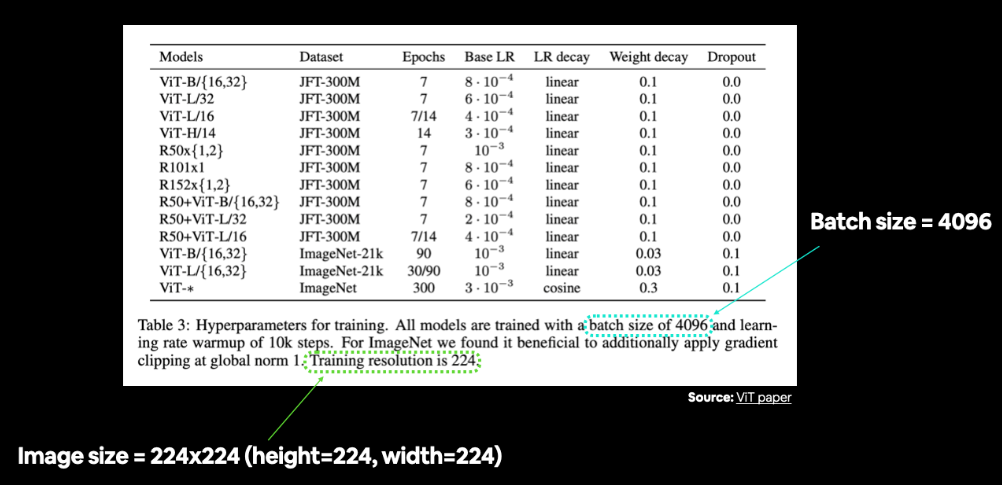

#### 2.1 Prepare transforms for images

In [9]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


#### 2.2 Turn images into DataLoader's

stick to batch size 32 instead of 4096

In [10]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f05ad80c850>,
 ['pizza', 'steak', 'sushi'])

#### 2.3 Visualize a single image

In [11]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

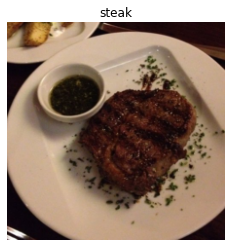

In [12]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

### 3.Replicating the ViT paper: an overview

We'd like to replicate the ViT paper for our own problem, FoodVision Mini.

So our **model inputs** are: images of pizza, steak and sushi.

And our ideal **model outputs** are: predicted labels of pizza, steak or sushi.

No different to what we've been doing throughout the previous sections.

The question is: how do we go from our inputs to the desired outputs?

#### 3.1 Inputs and outputs, layers and blocks

Let's make this concrete:

**Layer** - takes an input, performs a function on it, returns an output.

**Block** - a collection of layers, takes an input, performs a series of functions on it, returns an output.

**Architecture** (or model) - a collection of blocks, takes an input, performs a series of functions on it, returns an output.

This ideology is what we're going to be using to replicate the ViT paper.

We're going to take it layer by layer, block by block, function by function putting the pieces of the puzzle together like Lego to get our desired overall architecture.

The reason we do this is because looking at a whole research paper can be intimidating.

So for a better understanding, we'll break it down, starting with the inputs and outputs of single layer and working up to the inputs and outputs of the whole model.

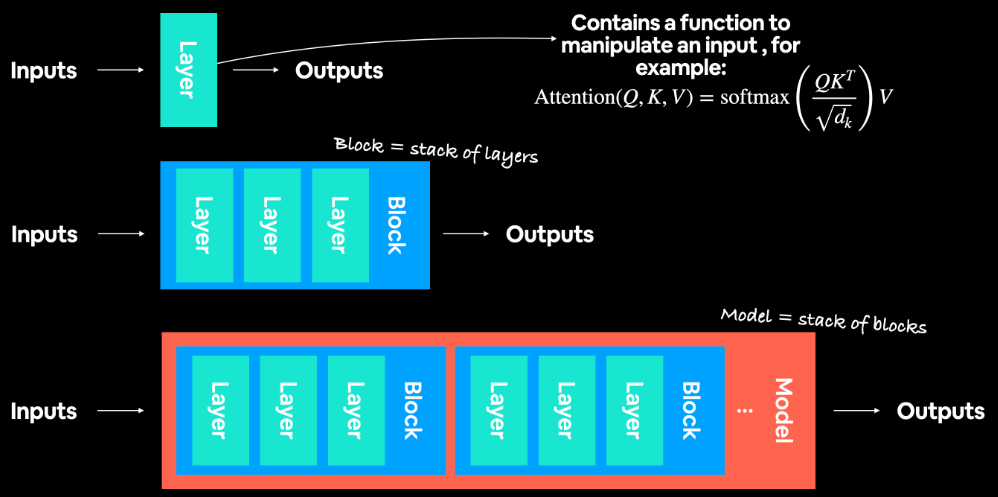

#### 3.1 Getting specific: What's ViT made of?

However, the main three resources we'll be looking at for the architecture design are:

1. Figure 1 - This gives an overview of the model in a graphical sense, you could almost recreate the architecture with this figure alone.

2. Four equations in section 3.1 - These equations give a little bit more of a mathematical grounding to the coloured blocks in Figure 1.

3. Table 1 - This table shows the various hyperparameter settings (such as number of layers and number of hidden units) for different ViT model variants. We'll be focused on the smallest version, ViT-Base.

##### 3.2.1 Exploring Figure 1

1. **Layers** - takes an input, performs an operation or function on the input, produces an output.

2. **Blocks** - a collection of layers, which in turn also takes an input and produces an output.

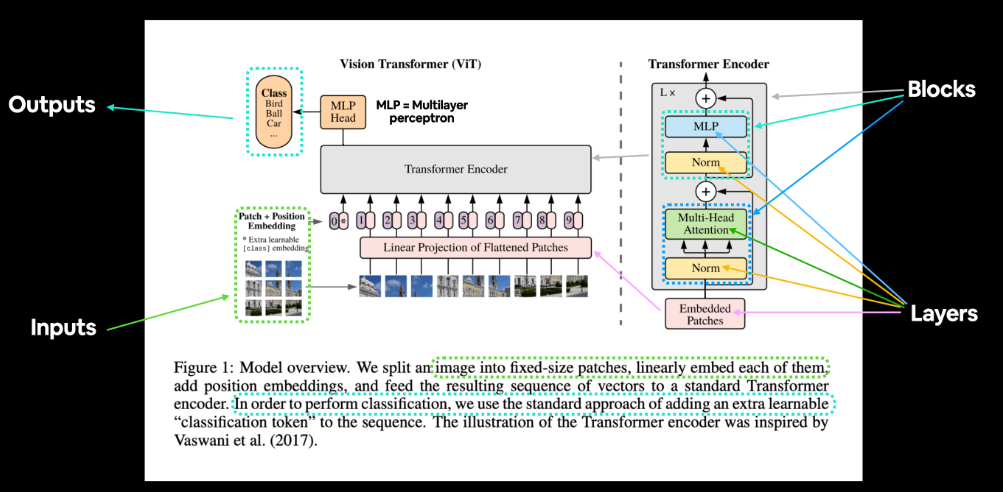

The ViT architecture is comprised of several stages:

**Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and add a position number what order the patch comes in.

**Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training.

**Norm** - This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer torch.nn.LayerNorm().

**Multi-Head Attention** - This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer torch.nn.MultiheadAttention().

**MLP (or Multilayer perceptron)** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a forward() method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two torch.nn.Linear() layers with a torch.nn.GELU() non-linearity activation in between them (section 3.1) and a torch.nn.Dropout() layer after each (Appendex B.1).

**Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.

**MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

You might notice that many of the pieces of the ViT architecture can be created with existing PyTorch layers.

This is because of how PyTorch is designed, it's one of the main purposes of PyTorch to create reusable neural network layers for both researchers and machine learning practitioners.

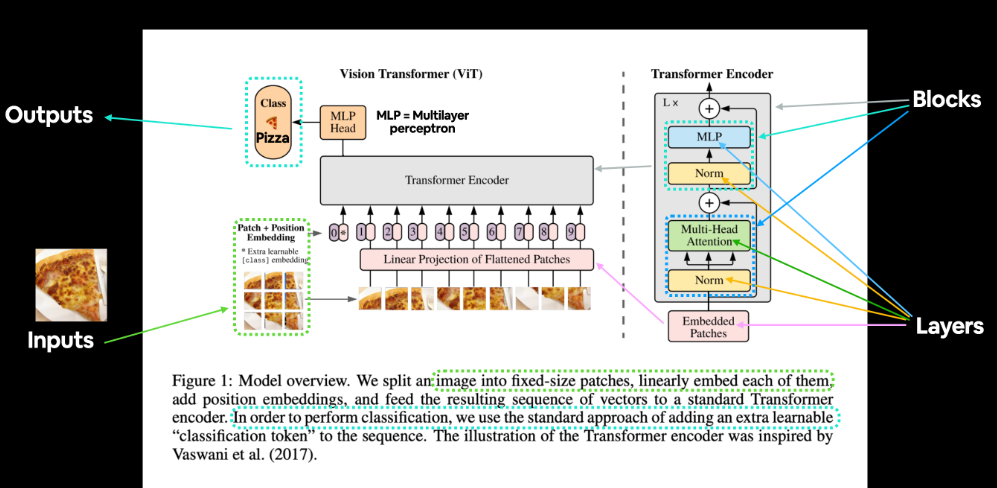

##### 3.2.2 Exploring the Four Equations

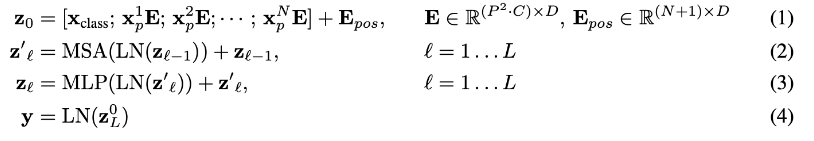

1. ...The Transformer uses constant latent vector size Dthrough all of its layers, so we flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings... Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings...

2. The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).

3. Same as equation 2.

4. 	Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches 
(z00=xclass ), whose state at the output of the Transformer encoder (z0L)
serves as the image representation y(Eq. 4)...

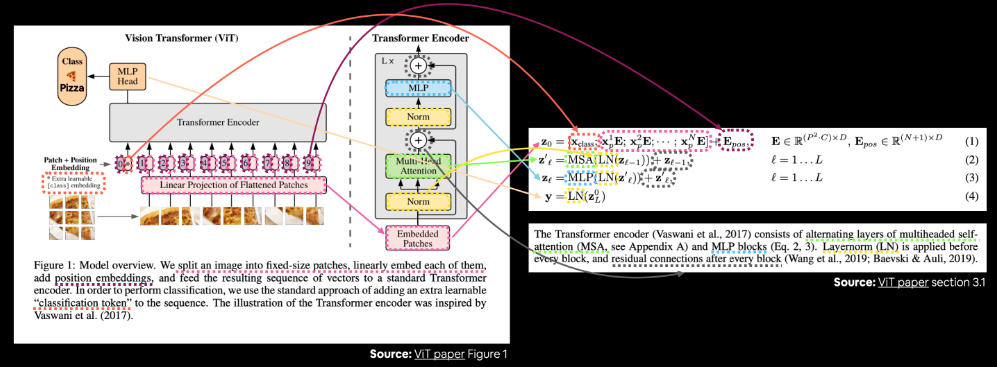

In all equations (except equation 4), "z" is the raw output of a particular
layer:

1. **z0** is "z zero" (this is the output of the initial patch embedding layer).

2. **z′ℓ** is "z of a particular layer prime" (or an intermediary value of z).

3. **zℓ** is "z of a particular layer".

And **y** is the overall output of the architecture.

##### 3.2.3 Equation 1 overview

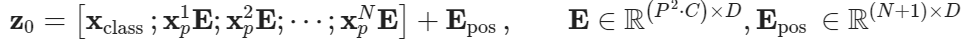

This equation deals with the class token, patch embedding and position embedding (
E
 is for embedding) of the input image.

In vector form, the embedding might look something like:

x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]

Where each of the elements in the vector is learnable (their requires_grad=True).

##### 3.2.4 Equation 2 overview

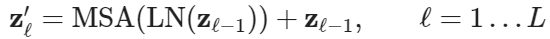

This says that for every layer from 
1
 through to 
L
 (the total number of layers), there's a Multi-Head Attention layer (MSA) wrapping a LayerNorm layer (LN).

The addition on the end is the equivalent of adding the input to the output and forming a skip/residual connection.

We'll call this layer the "MSA block".

In pseudocode, this might look like:

x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input
Notice the skip connection on the end (adding the input of the layers to the output of the layers).

##### 3.2.5 Equation 3 overview

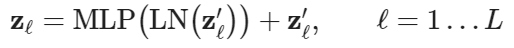

This says that for every layer from 
1
 through to 
L
 (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).

The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like:
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

Notice the skip connection on the end (adding the input of the layers to the output of the layers).

##### 3.2.6 Equation 4 overview

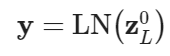

This says for the last layer 
L
, the output 
y
 is the 0 index token of 
z
 wrapped in a LayerNorm layer (LN).

Or in our case, the 0 index of x_output_MLP_block:

y = LN_layer(Linear_layer(x_output_MLP_block[0]))
Of course there are some simplifications above but we'll take care of those when we start to write PyTorch code for each section.

##### 3.2.7 Exploring Table 1

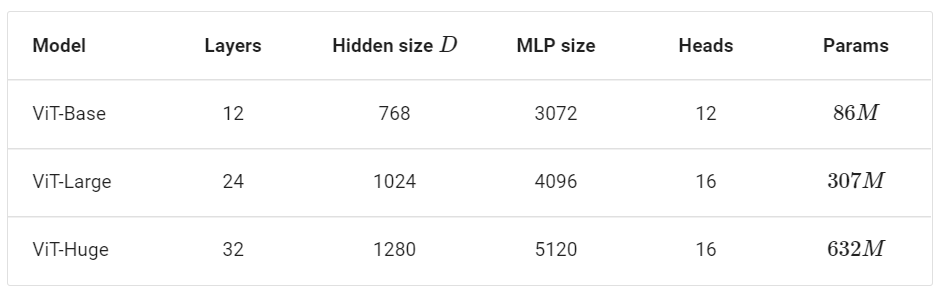

This table showcasing the various hyperparameters of each of the ViT architectures.

You can see the numbers gradually increase from ViT-Base to ViT-Huge.

We're going to focus on replicating ViT-Base (start small and scale up when necessary) but we'll be writing code that could easily scale up to the larger variants.

Breaking the hyperparameters down:

**Layers** - How many Transformer Encoder blocks are there? (each of these will contain a MSA block and MLP block)

**Hidden size D** - This is the embedding dimension throughout the architecture, this will be the size of the vector that our image gets turned into when it gets patched and embedded. Generally, the larger the embedding dimension, the more information can be captured, the better results. However, a larger embedding comes at the cost of more compute.

**MLP size** - What are the number of hidden units in the MLP layers?

**Heads** - How many heads are there in the Multi-Head Attention layers?

**Params** - What are the total number of parameters of the model? Generally, more parameters leads to better performance but at the cost of more compute. You'll notice even ViT-Base has far more parameters than any other model we've used so far.

We'll use these values as the hyperparameter settings for our ViT architecture.

#### 3.3 My workflow for replicating papers

When I start working on replicating a paper, I go through the following steps:

1. Read the whole paper end-to-end once (to get an idea of the main concepts).
2. Go back through each section and see how they line up with each other and start thinking about how they might be turned into code (just like above).
3. Repeat step 2 until I've got a fairly good outline.
4. Use mathpix.com (a very handy tool) to turn any sections of the paper into markdown/LaTeX to put into notebooks.
5. Replicate the simplest version of the model possible.
6. If I get stuck, look up other examples.

### 4.Equation 1: Split data into patches and creating the class, position and patch embedding

We'll start with the **patch embedding**.

This means we'll be turning our input images in a sequence of patches and then embedding those patches.

Recall that an embedding is a learnable representation of some form and is often a vector.

We'll begin by following the opening paragraph of section 3.1 of the ViT paper (bold mine):


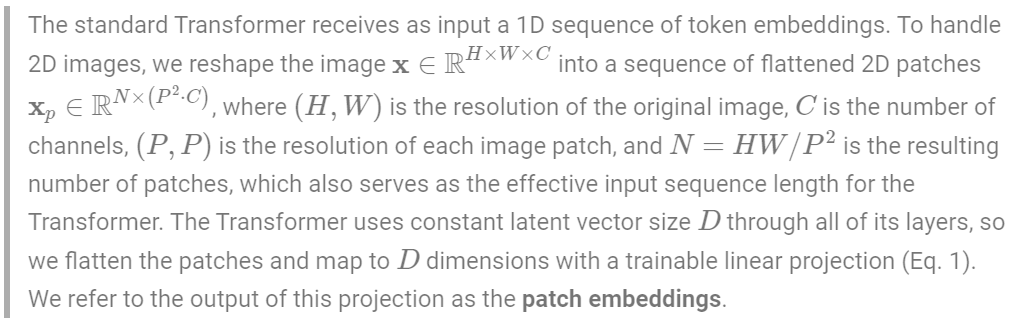

Let's break down the text above.

D is the size of the patch embeddings, different values for D
for various sized ViT models can be found in Table 1.

The image starts as 2D with size H×W×C.
(H,W)is the resolution of the original image (height, width).
C is the number of channels.

The image gets converted to a sequence of flattened 2D patches with size N×(P2⋅C).(P,P)is the resolution of each image patch (patch size).N=HW/P2
is the resulting number of patches, which also serves as the input sequence length for the Transformer.

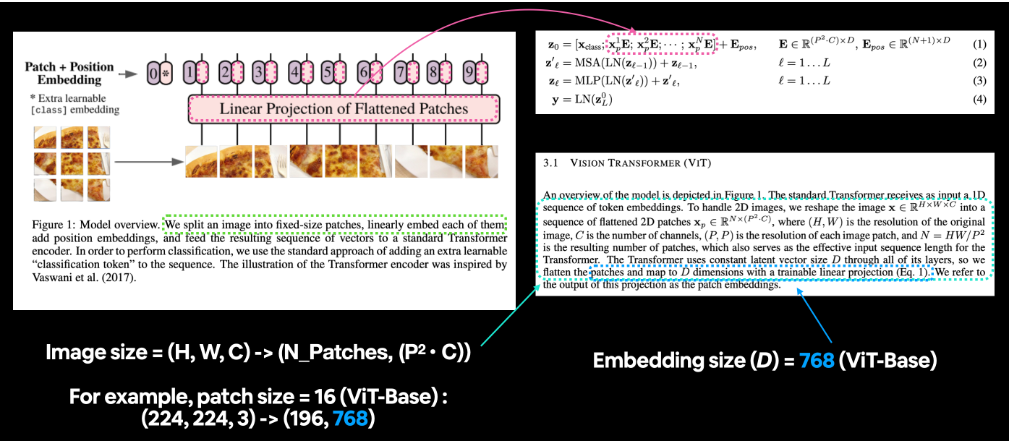

#### 4.1 Calculating patch embedding input and output shapes by hand

How about we start by calculating these input and output shape values by hand?

To do so, let's create some variables to mimic each of the terms (such as 
H
, 
W
 etc) above.

We'll use a patch size (
P
) of 16 since it's the best performing version of ViT-Base uses (see column "ViT-B/16" of Table 5 in the ViT paper for more).

In [10]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196



We've got the number of patches, how about we create the image output size as well?

Better yet, let's replicate the input and output shapes of the patch embedding layer.

Recall:

**Input:** The image starts as 2D with size 
H
×
W
×
C
.

**Output:** The image gets converted to a sequence of flattened 2D patches with size 
N
×
(
P
2
⋅
C
)
.

In [11]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


#### 4.2 Turning a single image into patches

Now we know the ideal input and output shapes for our patch embedding layer, let's move towards making it.

What we're doing is breaking down the overall architecture into smaller pieces, focusing on the inputs and outputs of individual layers.

So how do we create the patch embedding layer?

We'll get to that shortly, first, let's visualize, visualize, visualize! what it looks like to turn an image into patches.

Let's start with our single image.

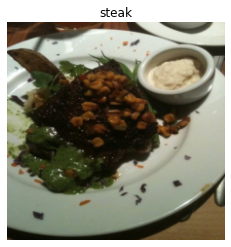

In [12]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);


We want to turn this image into patches of itself inline with Figure 1 of the ViT paper.

How about we start by just visualizing the top row of patched pixels?

We can do this by indexing on the different image dimensions.

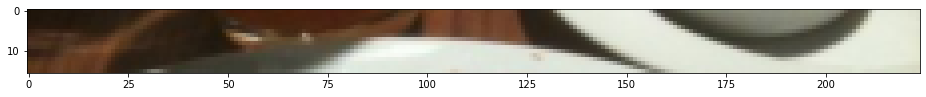

In [13]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


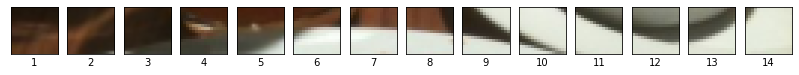

In [14]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, 
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


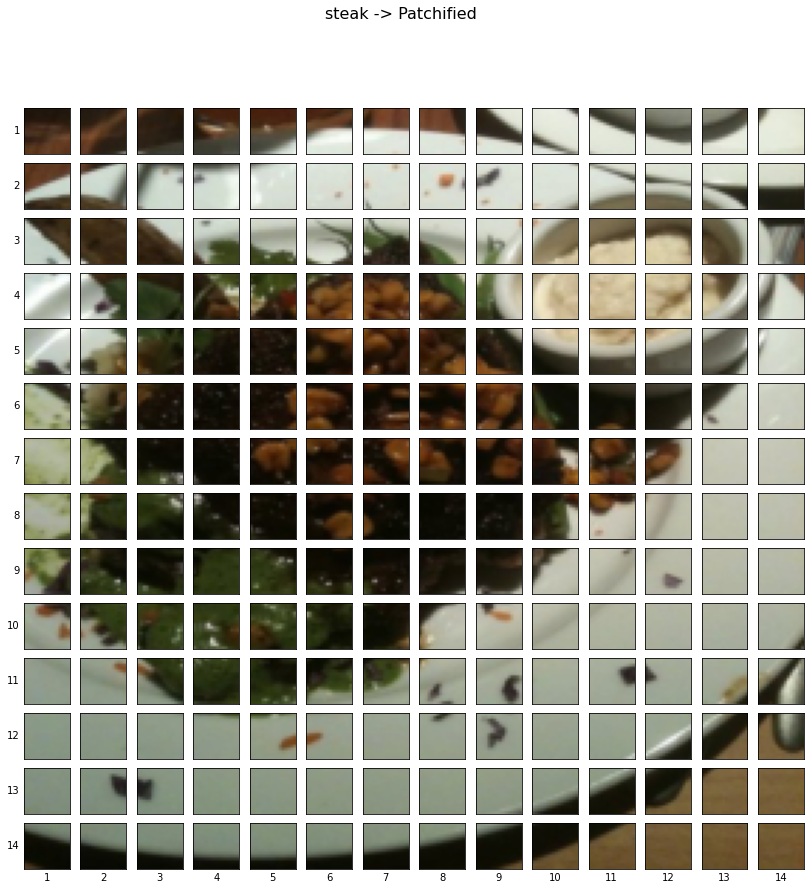

In [15]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size 
assert img_size % patch_size == 0, "Image size must be divisible by patch size" 
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size, 
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width
        
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height 
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

Now how do we turn each of these patches into an embedding and convert them into a sequence?

Hint: we can use PyTorch layers. Can you guess which?

#### 4.3 Creating image patches with torch.nn.Conv2d()

In fact, the authors of the ViT paper mention in section 3.1 that the patch embedding is achievable with a convolutional neural network (CNN):

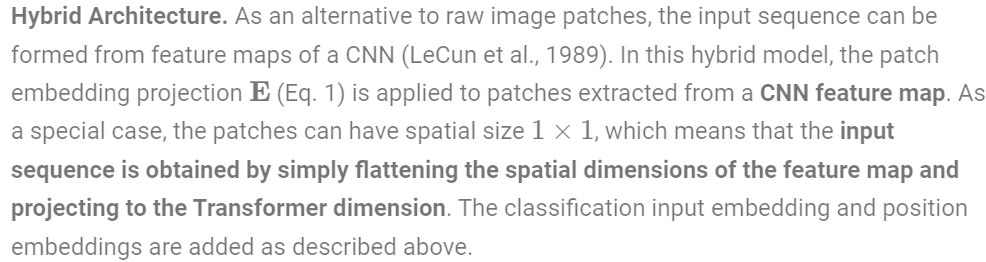

The "feature map" they're refering to are the weights/activations produced by a convolutional layer passing over a given image.

By setting the kernel_size and stride parameters of a torch.nn.Conv2d() layer equal to the patch_size, we can effectively get a layer that splits our image into patches and creates a learnable embedding (referred to as a "Linear Projection" in the ViT paper) of each patch.

Remember our ideal input and output shapes for the patch embedding layer?

**Input:** The image starts as 2D with size 
H
×
W
×
C
.

**Output:** The image gets converted to a 1D sequence of flattened 2D patches with size 
N
×
(
P
2
⋅
C
)
.

Or for an image size of 224 and patch size of 16:

**Input (2D image):** (224, 224, 3) -> (height, width, color channels)

**Output (flattened 2D patches):** (196, 768) -> (number of patches, embedding dimension)

We can recreate these with:

1. **torch.nn.Conv2d()** for turning our image into patches of CNN feature maps.

2. **torch.nn.Flatten()** for flattening the spatial dimensions of the feature map.

Let's start with the torch.nn.Conv2d() layer.

We can replicate the creation of patches by setting the kernel_size and stride equal to patch_size.

This means each convolutional kernel will be of size (patch_size x patch_size) or if patch_size=16, (16 x 16) (the equivalent of one whole patch).

And each step or stride of the convolutional kernel will be patch_size pixels long or 16 pixels long (equivalent of stepping to the next patch).

We'll set in_channels=3 for the number of color channels in our image and we'll set out_channels=768, the same as the 
D
 value in Table 1 for ViT-Base (this is the embedding dimension, each image will be embedded into a learnable vector of size 768).

In [16]:
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

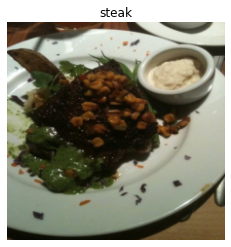

In [17]:
# View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);

In [18]:
# Pass the image through the convolutional layer 
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Passing our image through the convolutional layer turns it into a series of 768 (this is the embedding size or 
D
) feature/activation maps.

So its output shape can be read as:

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

Showing random convolutional feature maps from indexes: [262, 132, 80, 390, 205]


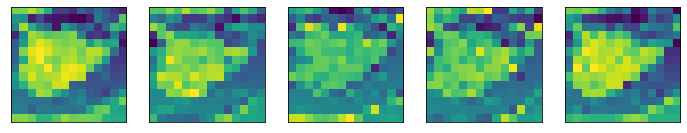

In [19]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [20]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.2251, -0.2368, -0.1392, -0.2027, -0.1632, -0.6170, -0.7886,
           -0.6651, -0.4826, -0.7627, -0.6385, -0.5111, -0.4918, -0.9968],
          [-0.5858, -0.7794, -0.7461, -0.8064, -0.9699, -0.9473, -0.9308,
           -0.9391, -0.7422, -0.9914, -0.8896, -0.8527, -0.6559, -0.4922],
          [-0.4778, -0.2363, -0.4727, -0.7410, -0.7551, -0.9187, -0.4247,
           -0.5963, -0.7944, -0.5316, -0.6281, -0.7715, -0.3681, -0.6015],
          [-0.9571, -0.4457, -0.1814, -0.2727, -0.2796, -0.2913, -0.2582,
           -0.2613, -0.6264, -0.8921, -0.8215, -0.7030, -0.7479, -0.7037],
          [-0.9491, -0.6935, -0.1361, -0.0808, -0.1074, -0.1654, -0.1850,
           -0.1608, -0.2162, -0.4034, -0.5087, -0.5457, -0.3821, -0.8639],
          [-0.6664, -0.3130, -0.0993, -0.0994, -0.0807, -0.1649, -0.1164,
           -0.1520, -0.2375, -0.1291, -0.1372, -0.0880, -0.5208, -0.8732],
          [-0.6795, -0.4447, -0.0410, -0.0505, -0.1597, -0.1261, -0.1576,
           -0.1188, -0.1899, -0.

The grad_fn output of the single_feature_map and the requires_grad=True attribute means PyTorch is tracking the gradients of this feature map and it will be updated by gradient descent during training.

#### 4.4 Flattening the patch embedding with torch.nn.Flatten()

We've turned our image into patch embeddings but they're still in 2D format.

How do we get them into the desired output shape of the patch embedding layer of the ViT model?

Desried output (1D sequence of flattened 2D patches): (196, 768) -> (number of patches, embedding dimension) ->  
N
×
(
P
2
⋅
C
)

In [21]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


Well we've got the 768 part ( 
(
P
2
⋅
C
)
 ) but we still need the number of patches (
N
).

Reading back through section 3.1 of the ViT paper it says (bold mine):

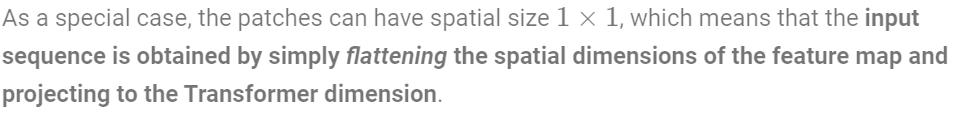

Flattening the spatial dimensions of the feature map hey?

What layer do we have in PyTorch that can flatten?

How about torch.nn.Flatten()?

But we don't want to flatten the whole tensor, we only want to flatten the "spatial dimensions of the feature map".

Which in our case is the feature_map_height and feature_map_width dimensions of image_out_of_conv.

So how about we create a torch.nn.Flatten() layer to only flatten those dimensions, we can use the start_dim and end_dim parameters to set that up?

In [22]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

We'll:

1. Take a single image.

2. Put in through the convolutional layer (conv2d) to turn the image into 2D feature maps (patch embeddings).

3. Flatten the 2D feature map into a single sequence.

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


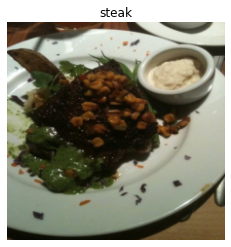

In [23]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

**Desried output** (flattened 2D patches): (196, 768) -> 
N
×
(
P
2
⋅
C
)

**Current shape:** (1, 768, 196)

In [24]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


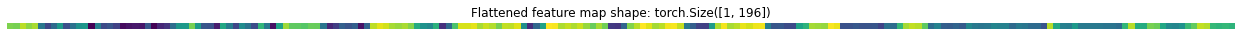

In [25]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [26]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.2251, -0.2368, -0.1392, -0.2027, -0.1632, -0.6170, -0.7886, -0.6651,
          -0.4826, -0.7627, -0.6385, -0.5111, -0.4918, -0.9968, -0.5858, -0.7794,
          -0.7461, -0.8064, -0.9699, -0.9473, -0.9308, -0.9391, -0.7422, -0.9914,
          -0.8896, -0.8527, -0.6559, -0.4922, -0.4778, -0.2363, -0.4727, -0.7410,
          -0.7551, -0.9187, -0.4247, -0.5963, -0.7944, -0.5316, -0.6281, -0.7715,
          -0.3681, -0.6015, -0.9571, -0.4457, -0.1814, -0.2727, -0.2796, -0.2913,
          -0.2582, -0.2613, -0.6264, -0.8921, -0.8215, -0.7030, -0.7479, -0.7037,
          -0.9491, -0.6935, -0.1361, -0.0808, -0.1074, -0.1654, -0.1850, -0.1608,
          -0.2162, -0.4034, -0.5087, -0.5457, -0.3821, -0.8639, -0.6664, -0.3130,
          -0.0993, -0.0994, -0.0807, -0.1649, -0.1164, -0.1520, -0.2375, -0.1291,
          -0.1372, -0.0880, -0.5208, -0.8732, -0.6795, -0.4447, -0.0410, -0.0505,
          -0.1597, -0.1261, -0.1576, -0.1188, -0.1899, -0.2585, -0.1671, -0.2471,
          -0.835

#### 4.5 Turning the ViT patch embedding layer into a PyTorch module

Time to put everything we've done for creating the patch embedding into a single PyTorch layer.

We can do so by subclassing nn.Module and creating a small PyTorch "model" to do all of the steps above.

Specifically we'll:

1. Create a class called PatchEmbedding which subclasses nn.Module (so it can be used a PyTorch layer).

2. Initialize the class with the parameters in_channels=3, patch_size=16 (for ViT-Base) and embedding_dim=768 (this is 
D
 for ViT-Base from Table 1).

3. Create a layer to turn an image into patches using nn.Conv2d() (just like in 4.3 above).

4. Create a layer to flatten the patch feature maps into a single dimension (just like in 4.4 above).

5. Define a forward() method to take an input and pass it through the layers created in 3 and 4.

6. Make sure the output shape reflects the required output shape of the ViT architecture (
N
×
(
P
2
⋅
C
)
).

In [27]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [28]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [29]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(), 
        input_size=random_input_image, # try swapping this for "random_input_image_error" 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

#### 4.6 Creating the class token embedding

x
class 
 from equation 1

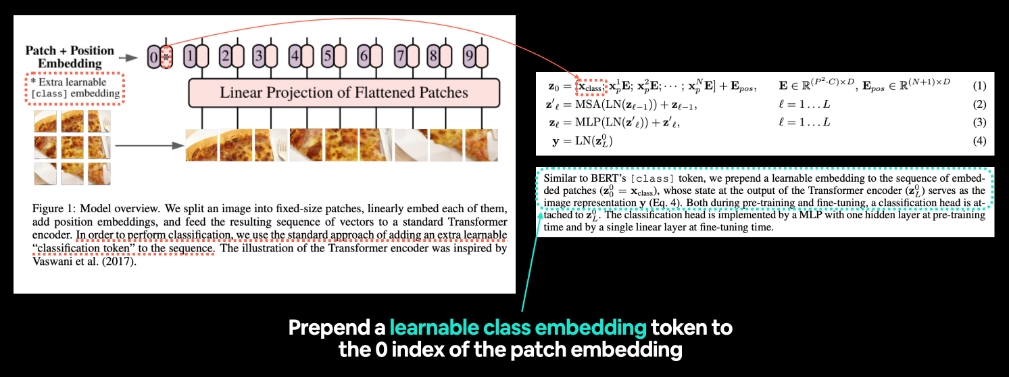

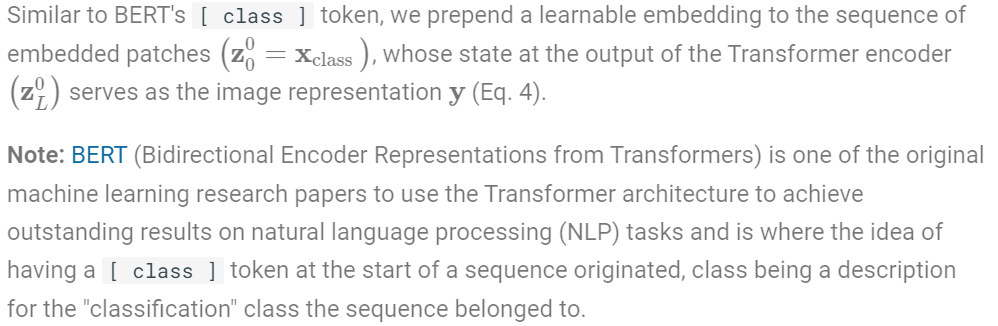

In [30]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.2568,  0.0117, -0.0817,  ...,  0.1602, -0.1046,  0.1032],
         [-0.2874,  0.0375, -0.0875,  ...,  0.0341, -0.0156,  0.1673],
         [-0.1339,  0.0468, -0.1132,  ...,  0.1367, -0.0624,  0.0672],
         ...,
         [-0.3754,  0.0653, -0.0699,  ...,  0.2649, -0.2043,  0.1423],
         [-0.3790,  0.0665, -0.0631,  ...,  0.2450, -0.2052,  0.1335],
         [-0.3847,  0.0551, -0.0753,  ...,  0.2540, -0.2001,  0.1331]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]



To "prepend a learnable embedding to the sequence of embedded patches" we need to create a learnable embedding in the shape of the embedding_dimension (
D
) and then add it to the number_of_patches dimension.

Or in pseudocode:

patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)

In [31]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [32]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.2568,  0.0117, -0.0817,  ...,  0.1602, -0.1046,  0.1032],
         [-0.2874,  0.0375, -0.0875,  ...,  0.0341, -0.0156,  0.1673],
         ...,
         [-0.3754,  0.0653, -0.0699,  ...,  0.2649, -0.2043,  0.1423],
         [-0.3790,  0.0665, -0.0631,  ...,  0.2450, -0.2052,  0.1335],
         [-0.3847,  0.0551, -0.0753,  ...,  0.2540, -0.2001,  0.1331]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


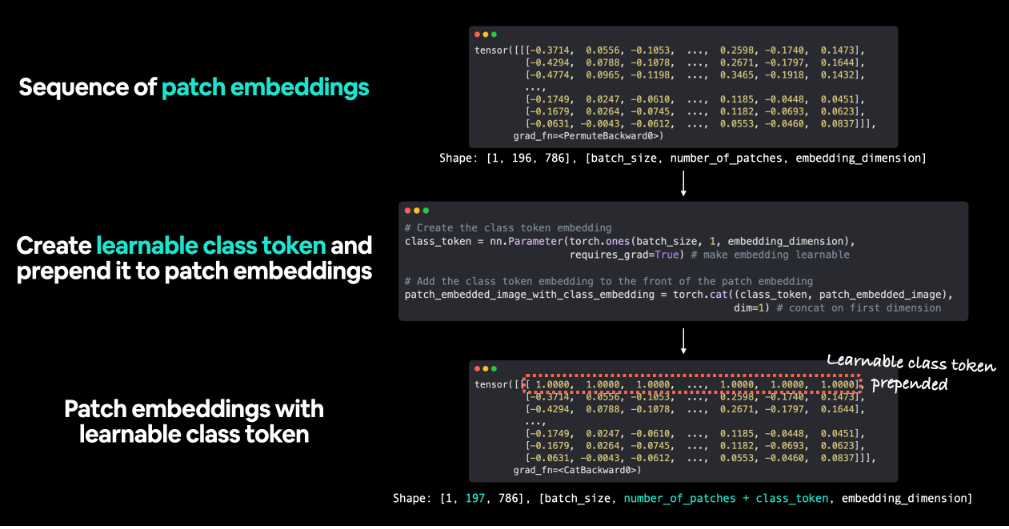

#### 4.7 Creating the position embedding

E
pos 
 from equation 1 where 
E
 stands for "embedding".

 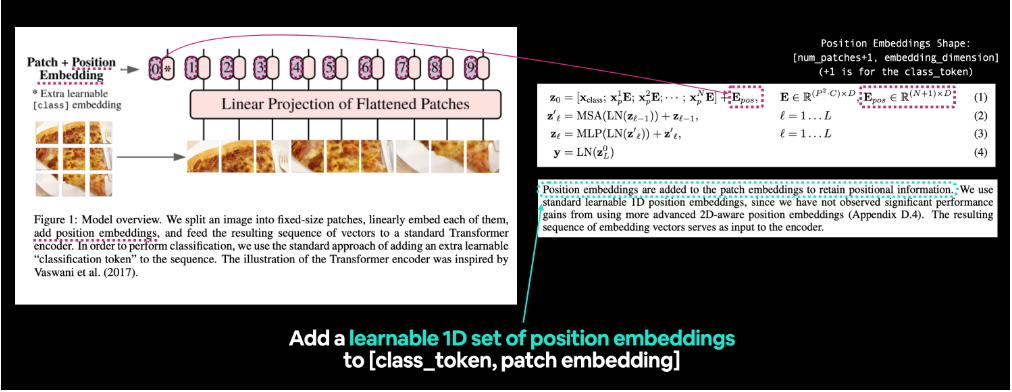

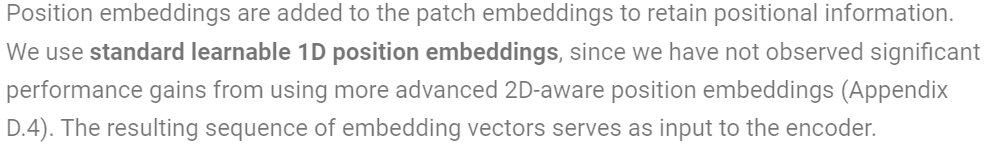

By "retain positional information" the authors mean they want the architecture to know what "order" the patches come in. As in, patch two comes after patch one and patch three comes after patch two and on and on.

This positional information can be important when considering what's in an image (without positional information an a flattened sequence could be seen as having no order and thus no patch relates to any other patch).

To start creating the position embeddings, let's view our current embeddings.

In [33]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.2568,  0.0117, -0.0817,  ...,  0.1602, -0.1046,  0.1032],
          [-0.2874,  0.0375, -0.0875,  ...,  0.0341, -0.0156,  0.1673],
          ...,
          [-0.3754,  0.0653, -0.0699,  ...,  0.2649, -0.2043,  0.1423],
          [-0.3790,  0.0665, -0.0631,  ...,  0.2450, -0.2052,  0.1335],
          [-0.3847,  0.0551, -0.0753,  ...,  0.2540, -0.2001,  0.1331]]],
        grad_fn=<CatBackward0>), torch.Size([1, 197, 768]))


Equation 1 states that the position embeddings (
E
pos 
) should have the shape 
(
N
+
1
)
×
D
:

E
pos 
∈
R
(
N
+
1
)
×
D

Where:

1. **N=HW/P2**
 is the resulting number of patches, which also serves as the effective input sequence length for the Transformer (number of patches).
2. D
 is the size of the patch embeddings, different values for 
D
 can be found in Table 1 (embedding dimension).

In [34]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


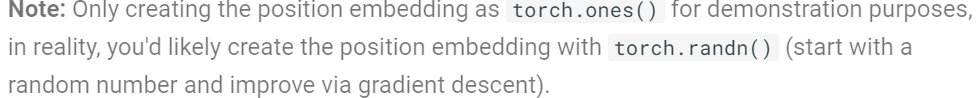

In [35]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7432, 1.0117, 0.9183,  ..., 1.1602, 0.8954, 1.1032],
         [0.7126, 1.0375, 0.9125,  ..., 1.0341, 0.9844, 1.1673],
         ...,
         [0.6246, 1.0653, 0.9301,  ..., 1.2649, 0.7957, 1.1423],
         [0.6210, 1.0665, 0.9369,  ..., 1.2450, 0.7948, 1.1335],
         [0.6153, 1.0551, 0.9247,  ..., 1.2540, 0.7999, 1.1331]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]



Notice how the values of each of the elements in the embedding tensor increases by 1 (this is because of the position embeddings being created with torch.ones()).

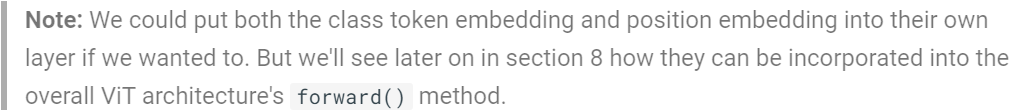

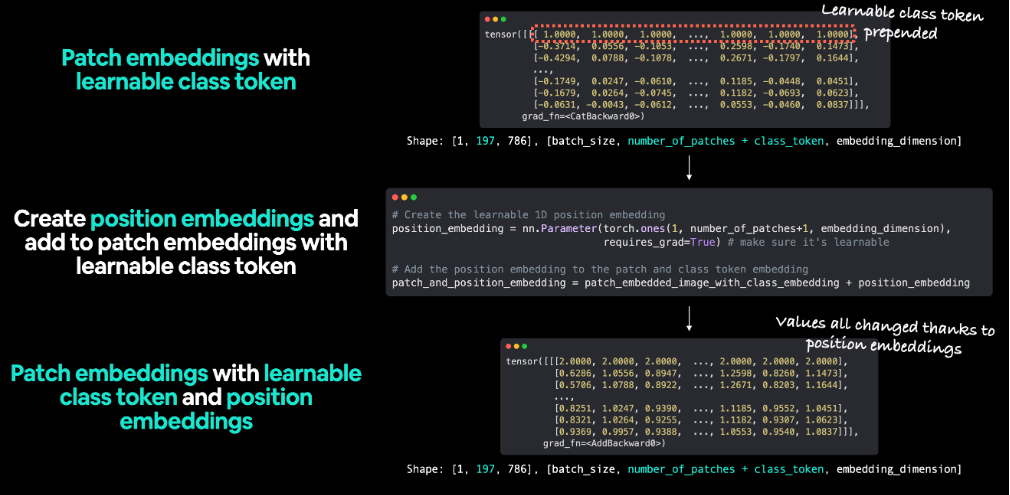

#### 4.8 Putting it all together: from image to embedding

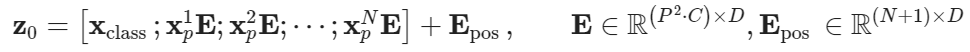

Let's now put everything together in a single code cell and go from input image (
x
) to output embedding (
z
0
).

We can do so by:

1. Setting the patch size (we'll use 16 as it's widely used throughout the paper and for ViT-Base).
2. Getting a single image, printing its shape and storing its height and width.
3. Adding a batch dimension to the single image so it's compatible with our PatchEmbedding layer.
4. Creating a PatchEmbedding layer (the one we made in section 4.5) with a patch_size=16 and embedding_dim=768 (from Table 1 for ViT-Base).
5. Passing the single image through the PatchEmbedding layer in 4 to create a sequence of patch embeddings.
6. Creating a class token embedding like in section 4.6.
7. Prepending the class token emebdding to the patch embeddings created in step 5.
8. Creating a position embedding like in section 4.7.
9. Adding the position embedding to the class token and patch embeddings created in step 7.

In [36]:
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


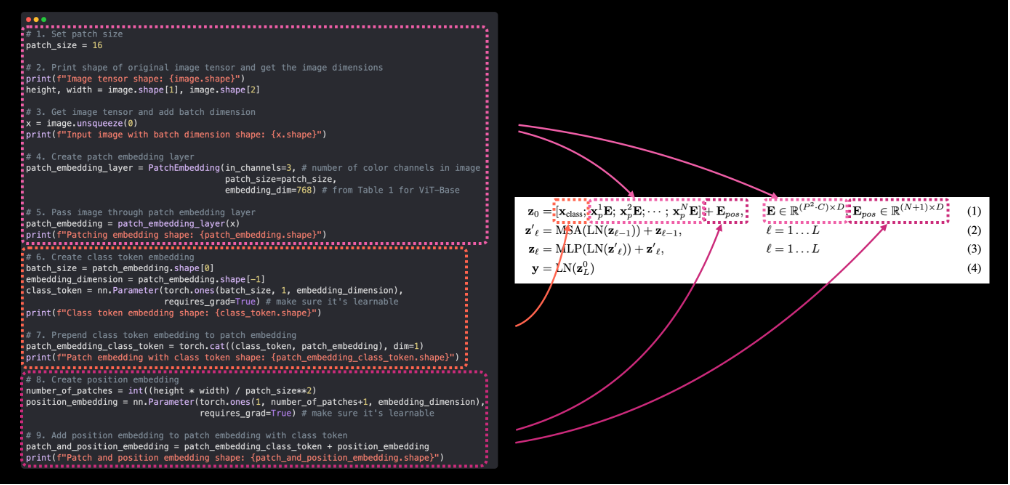

### 5.Equation 2: Multi-Head Attention (MSA)

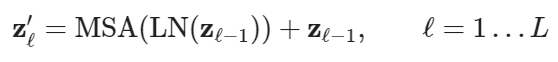


5. Equation 2: Multi-Head Attention (MSA)
We've got our input data patchified and embedded, now let's move onto the next part of the ViT architecture.

To start, we'll break down the Transformer Encoder section into two parts (start small and increase when necessary).

The first being equation 2 and the second being equation 3.

Recall equation 2 states:

z
′
ℓ
=
MSA
(
LN
(
z
ℓ
−
1
)
)
+
z
ℓ
−
1
,
ℓ
=
1
…
L
This indicates a Multi-Head Attention (MSA) layer wrapped in a LayerNorm (LN) layer with a residual connection (the input to the layer gets added to the output of the layer).

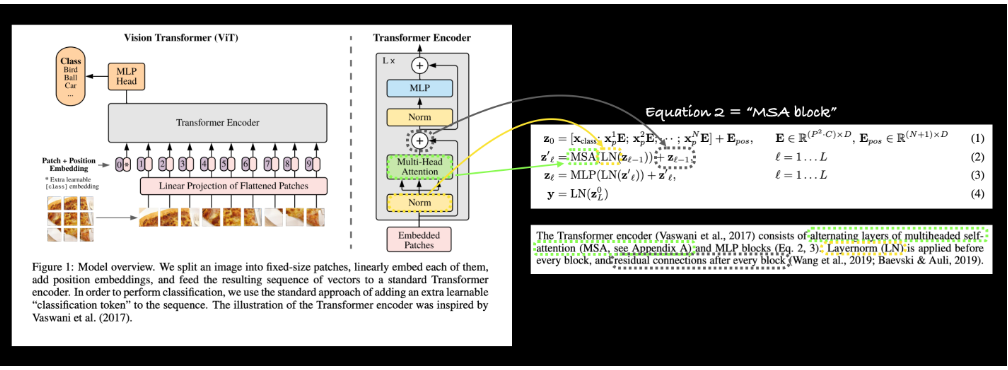

Many layers you find in research papers are already implemented in modern deep learning frameworks such as PyTorch.

In saying this, to replicate these layers and residual connection with PyTorch code we can use:

1. **Multi-Head Self Attention (MSA**) - torch.nn.MultiheadAttention().
2. **Norm (LN or LayerNorm)** - torch.nn.LayerNorm().
3. **Residual connection** - add the input to output (we'll see this later on when we create the full Transformer Encoder block in section 7.1).

#### 5.1 The LayerNorm (LN) layer

Layer Normalization (torch.nn.LayerNorm() or Norm or LayerNorm or LN) normalizes an input over the last dimension.

Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data).

#### 5.2 The Multi-Head Self Attention (MSA) layer

Originally designed for text inputs, the original self-attention mechanism takes a sequence of words and then calculates which word should pay more "attention" to another word.

In other words, in the sentence "the dog jumped over the fence", perhaps the word "dog" relates strongly to "jumped" and "fence".

This is simplified but the premise remains for images.

Since our input is a sequence of image patches rather than words, self-attention and in turn multi-head attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of an image.

But what's most important is that the layer does this on it's own given the data (we don't tell it what patterns to learn).

And if the learned representation the layers form using MSA are good, we'll see the results in our model's performance.

There are many resources online to learn more about the Transformer architeture and attention mechanism online such as Jay Alammar's wonderful Illustrated Transformer post and Illustrated Attention post.

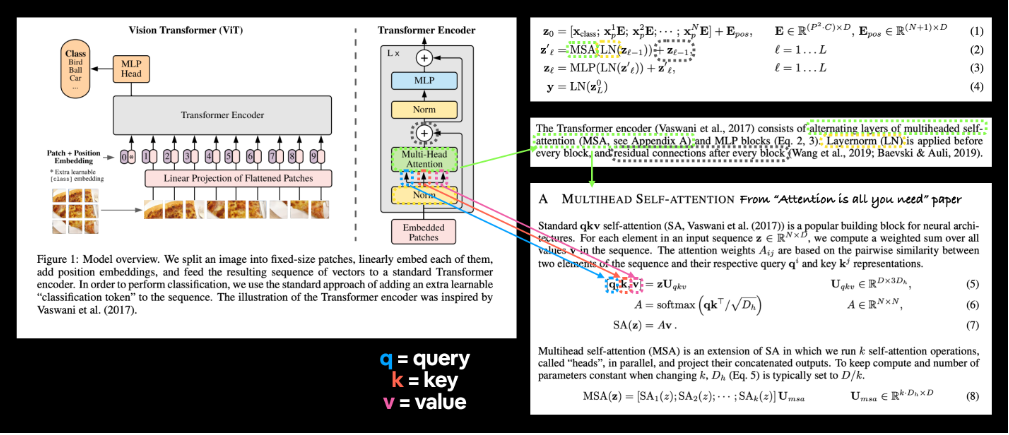

The image above highlights the triple embedding input to the MSA layer.

This is known as **query**, **key**, **value** input or **qkv** for short which is fundamental to the self-attention mechanism.

In our case, the triple embedding input will be three versions of the output of the Norm layer, one for query, key and value.

Or three versions of our layer-normalized image patch and position embeddings created in section 4.8.

We can implement the MSA layer in PyTorch with torch.nn.MultiheadAttention() with the parameters:

1. embed_dim - the embedding dimension from Table 1 (Hidden size 
D
).
2. num_heads - how many attention heads to use (this is where the term "multihead" comes from), this value is also in Table 1 (Heads).
3. dropout - whether or not to apply dropout to the attention layer (according to Appendix B.1, dropout isn't used after the qkv-projections).
4. batch_first - does our batch dimension come first? (yes it does)

#### 5.3 Replicating Equation 2 with PyTorch layers

To do so, we'll:

1. Create a class called MultiheadSelfAttentionBlock that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with torch.nn.LayerNorm() with the normalized_shape parameter the same as our embedding dimension (
D
 from Table 1).
4. Create a multi-head attention (MSA) layer with the appropriate embed_dim, num_heads, dropout and batch_first parameters.
5. Create a forward() method for our class passing the in the inputs through the LN layer and MSA layer.

In [37]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:int=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

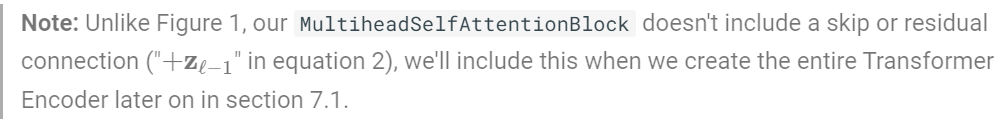

In [38]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1 
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


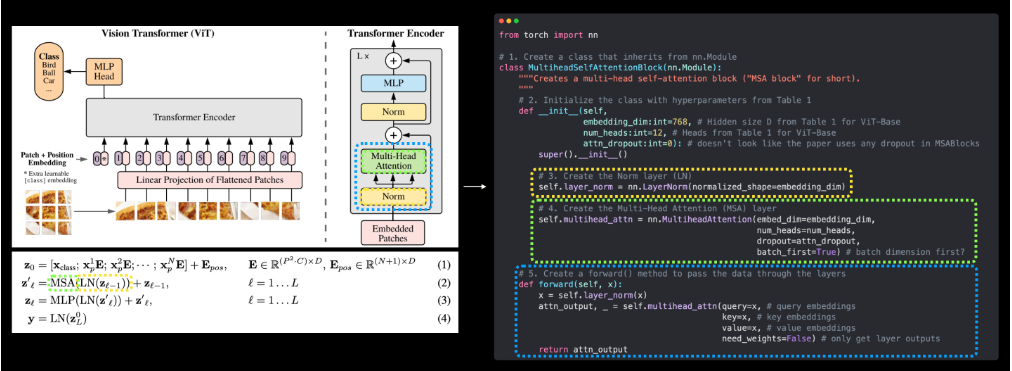

### 6.Equation 3: Multilayer Perceptron (MLP)

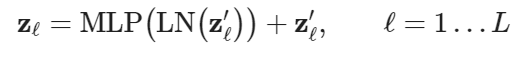

Here MLP stands for "multilayer perceptron" and LN stands for "layer normalization" (as discussed above).

And the addition on the end is the skip/residual connection.

We'll refer to equation 3 as the "MLP block" of the Transformer encoder (notice how we're continuing the trend of breaking down the architecture into smaller chunks).

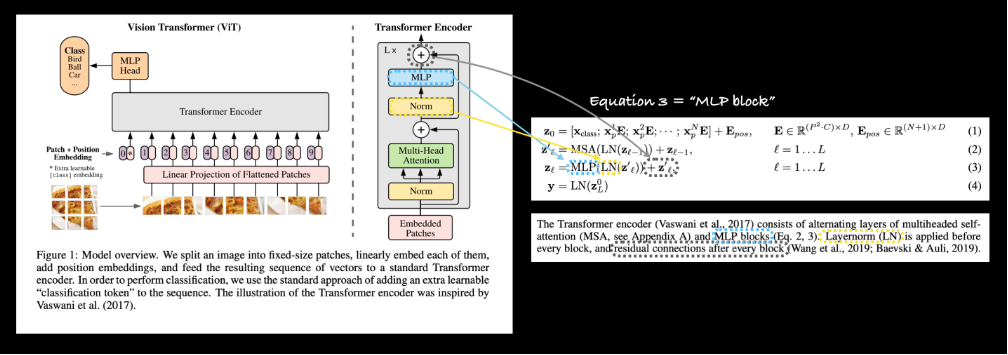

#### 6.1 The MLP layer(s)

The term MLP is quite broad as it can refer to almost any combination of multiple layers (hence the "multi" in multilayer perceptron).

But it generally follows the pattern of:
linear layer -> non-linear layer -> linear layer -> non-linear layer

In the the case of the ViT paper, the MLP structure is defined in section 3.1:

**The MLP contains two layers with a GELU non-linearity.**

Where "two layers" refers to linear layers (torch.nn.Linear() in PyTorch) and "GELU non-linearity" is the GELU (Gaussian Error Linear Units) non-linear activation function (torch.nn.GELU() in PyTorch).

**Note:** A linear layer (torch.nn.Linear()) can sometimes also be referred to as a "dense layer" or "feedforward layer". Some papers even use all three terms to describe the same thing (as in the ViT paper).

Another sneaky detail about the MLP block doesn't appear until Appendix B.1 (Training):

**Table 3 summarizes our training setups for our different models. ...Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.**

This means that every linear layer (or dense layer) in the MLP block has a dropout layer (torch.nn.Dropout() in PyTorch).

The value of which can be found in Table 3 of the ViT paper (for ViT-Base, **dropout=0.1**).

Knowing this, the structure of our MLP block will be:

layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout

With hyperparameter values for the linear layers available from Table 1 (MLP size is the number of hidden units between the linear layers and hidden size 
D
 is the output size of the MLP block).

#### 6.2 Replicating Equation 3 with PyTorch layers

To do so, we'll:

1. Create a class called MLPBlock that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with torch.nn.LayerNorm() with the normalized_shape parameter the same as our embedding dimension (
D
 from Table 1).
4. Create a sequential series of MLP layers(s) using torch.nn.Linear(), torch.nn.Dropout() and torch.nn.GELU() with appropriate hyperparameter values from Table 1 and Table 3.
5. Create a forward() method for our class passing the in the inputs through the LN layer and MLP layer(s).

In [39]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:int=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

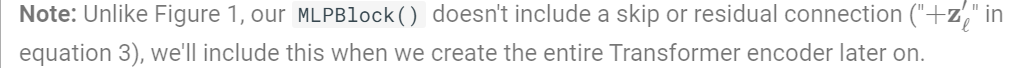

In [40]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1 
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


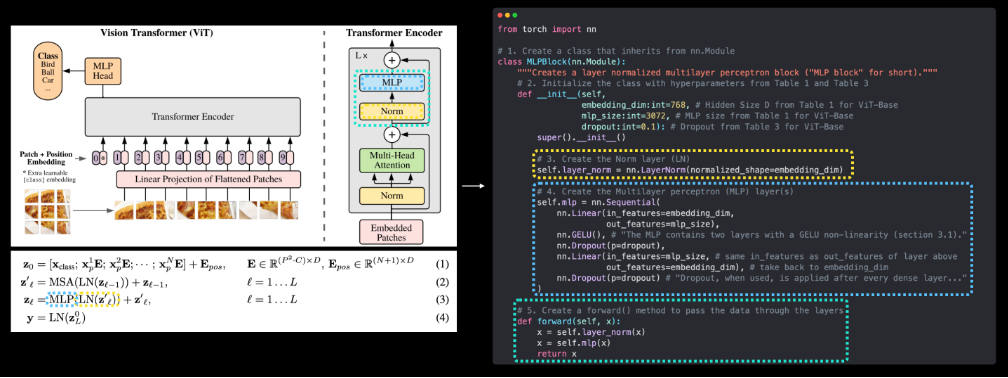

### 7.Create the Transformer Encoder

Time to stack together our MultiheadSelfAttentionBlock (equation 2) and MLPBlock (equation 3) and create the Transformer Encoder of the ViT architecture.

In deep learning, an "encoder" or "auto encoder" generally refers to a stack of layers that "encodes" an input (turns it into some form of numerical representation).

In our case, the Transformer Encoder will encode our patched image embedding into a learned representation using a series of alternating layers of MSA blocks and MLP blocks, as per section 3.1 of the ViT Paper:

**Residual connections** (also called skip connections), were first introduced in the paper Deep Residual Learning for Image Recognition and are achieved by adding a layer(s) input to its subsequent output.

Where the subsequence output might be one or more layers later.

In the case of the ViT architecture, the residual connection means the input of the MSA block is added back to the output of the MSA block before it passes to the MLP block.

And the same thing happens with the MLP block before it goes onto the next Transformer Encoder block.

Or in pseudocode:

x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...

One of the main ideas behind residual connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned.

#### 7.1 Creating a Transformer Encoder by combining our custom made layers

To do so, we'll:

1. Create a class called TransformerEncoderBlock that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Instantiate a MSA block for equation 2 using our MultiheadSelfAttentionBlock from section 5.2 with the appropriate parameters.
4. Instantiate a MLP block for equation 3 using our MLPBlock from section 6.2 with the appropriate parameters.
5. Create a forward() method for our TransformerEncoderBlock class.
6. Create a residual connection for the MSA block (for equation 2).
7. Create a residual connection for the MLP block (for equation 3).

In [41]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:int=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:int=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

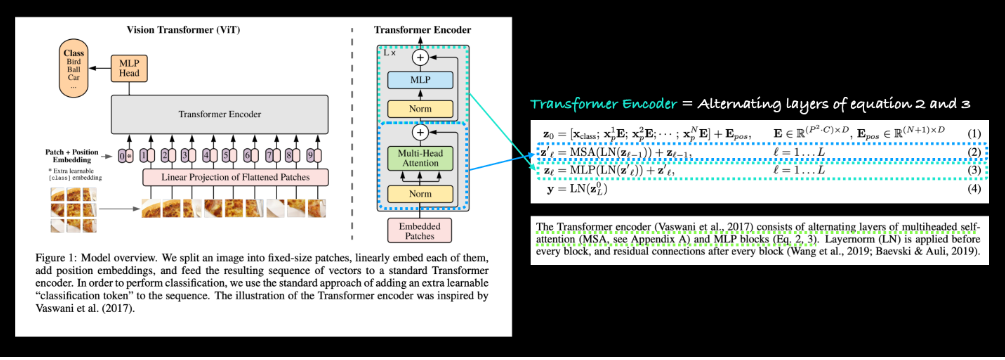

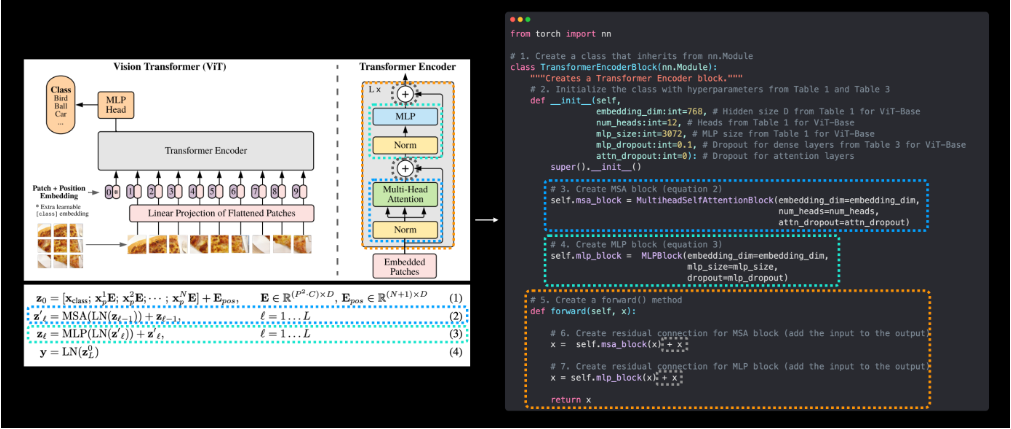

In [42]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

#### 7.2 Creating a Transformer Encoder with PyTorch's Transformer layers

So far we've built the components of and the Transformer Encoder layer itself ourselves.

But because of their rise in popularity and effectiveness, PyTorch now has in-built Transformer layers as part of torch.nn.

For example, we can recreate the TransformerEncoderBlock we just created using torch.nn.TransformerEncoderLayer() and setting the same hyperparameters as above.

In [45]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [46]:
# # Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Finally, since the ViT architecture uses several Transformer Layers stacked on top of each for the full architecture (Table 1 shows 12 Layers in the case of ViT-Base), you can do this with torch.nn.TransformerEncoder(encoder_layer, num_layers) where:

1. encoder_layer - The target Transformer Encoder layer created with torch.nn.TransformerEncoderLayer().
2. num_layers - The number of Transformer Encoder layers to stack together.

### 8.Putting it all together to create ViT

We're going to combine all of the blocks we've created to replicate the full ViT architecture.

From the patch and positional embedding to the Transformer Encoder(s) to the MLP Head.

But wait, we haven't created equation 4 yet...

**y=LN(z0L)**

Don't worry, we can put equation 4 into our overall ViT architecture class.

All we need is a torch.nn.LayerNorm() layer and a torch.nn.Linear() layer to convert the 0th index (
z
0
L
) of the Transformer Encoder logit outputs to the target number of classes we have.

To create the full architecture, we'll also need to stack a number of our TransformerEncoderBlocks on top of each other, we can do this by passing a list of them to torch.nn.Sequential() (this will make a sequential range of TransformerEncoderBlocks).

We'll focus on the ViT-Base hyperparameters from Table 1 but our code should be adaptable to other ViT variants.

Finally, to bring our own implementation of ViT to life, let's:

1. Create a class called ViT that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Make sure the image size is divisible by the patch size (the image should be split into even patches).
4. Calculate the number of patches using the formula 
N
=
H
W
/
P
2
, where 
H
 is the image height, 
W
 is the image width and 
P
 is the patch size.
5. Create a learnable class embedding token (equation 1) as done above in section 4.6.
6. Create a learnable position embedding vector (equation 1) as done above in section 4.7.
7. Setup the embedding dropout layer as discussed in Appendix B.1 of the ViT paper.
8. Create the patch embedding layer using the PatchEmbedding class as above in section 4.5.
9. Create a series of Transformer Encoder blocks by passing a list of TransformerEncoderBlocks created in section 7.1 to torch.nn.Sequential() (equations 2 & 3).
10. Create the MLP head (also called classifier head or equation 4) by passing a torch.nn.LayerNorm() (LN) layer and a torch.nn.Linear(out_features=num_classes) layer (where num_classes is the target number of classes) linear layer to torch.nn.Sequential().
11. Create a forward() method that accepts an input.
12. Get the batch size of the input (the first dimension of the shape).
13. Create the patching embedding using the layer created in step 8 (equation 1).
14. Create the class token embedding using the layer created in step 5 and expand it across the number of batches found in step 11 using torch.Tensor.expand() (equation 1).
15. Concatenate the class token embedding created in step 13 to the first dimension of the patch embedding created in step 12 using torch.cat() (equation 1).
16. Add the position embedding created in step 6 to the patch and class token embedding created in step 14 (equation 1).
17. Pass the patch and position embedding through the dropout layer created in step 7.
18. Pass the patch and position embedding from step 16 through the stack of Transformer Encoder layers created in step 9 (equations 2 & 3).
19. Pass index 0 of the output of the stack of Transformer Encoder layers from step 17 through the classifier head created in step 10 (equation 4).
20. Dance and shout woohoo!!! We just built a Vision Transformer!

In [47]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:int=0, # Dropout for attention projection
                 mlp_dropout:int=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:int=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [48]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [49]:
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

#### 8.1 Getting a visual summary of our ViT model

In [53]:
from torchinfo import summary

# # Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        #col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

### 9. Setting up training code for our ViT model

To train our model we can import the train() function from going_modular.going_modular.engine.

All we need is a loss function and an optimizer.

#### 9.1  Creating an optimizer

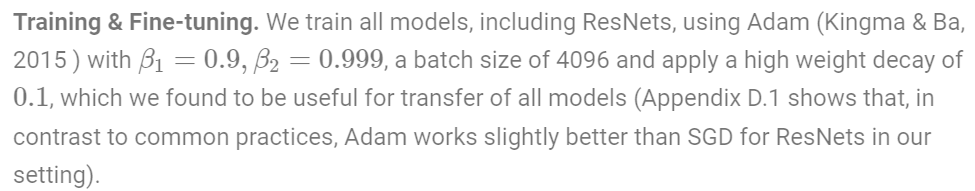

So we can see they chose to use the "Adam" optimizer (torch.optim.Adam()) rather than SGD (stochastic gradient descent, torch.optim.SGD()).

The authors set Adam's 
β
 (beta) values to 
β
1
=
0.9
,
β
2
=
0.999
, these are the default values for the betas parameter in torch.optim.Adam(betas=(0.9, 0.999)).

They also state the use of weight decay (slowly reducing the values of the weights during optimization to prevent overfitting), we can set this with the weight_decay parameter in torch.optim.Adam(weight_decay=0.1).

We'll set the learning rate of the optimizer to 0.1 as per Table 3.

And as discussed previously, we're going to use a lower batch size than 4096 due to hardware limitations (if you have a large GPU, feel free to increase this).

#### 9.2 Creating a loss function

Strangely, searching the ViT paper for "loss" or "loss function" or "criterion" returns no results.

However, since the target problem we're working with is multi-class classification (the same for the ViT paper), we'll use torch.nn.CrossEntropyLoss().

#### 9.3 Training our ViT model

In [54]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=1e-3, # Base LR from Table 3 
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.1) # from the ViT paper section 4.1 (Training & Fine-tuning)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.8769 | train_acc: 0.3008 | test_loss: 1.0393 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3047 | test_loss: 1.5086 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4133 | train_acc: 0.2617 | test_loss: 1.4602 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2590 | train_acc: 0.4102 | test_loss: 1.9580 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.3003 | train_acc: 0.2812 | test_loss: 1.6453 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2523 | train_acc: 0.2969 | test_loss: 1.7505 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1795 | train_acc: 0.4102 | test_loss: 3.2499 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.4590 | train_acc: 0.2852 | test_loss: 1.3793 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.3395 | train_acc: 0.3672 | test_loss: 1.2891 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.4096 | train_acc: 0.3164 | test_loss: 1.3273 | test_acc: 0.2604


#### 9.4 What our training setup is missing

The original ViT architecture achieves good results on several image classification benchmarks (on par or better than many state-of-the-art results when it was released).

However, our results (so far) aren't as good.

There's a few reasons this could be but the main one is scale.

The original ViT paper uses a far larger amount of data than ours (in deep learning, more data is generally always a good thing) and a longer training schedule (see Table 3).

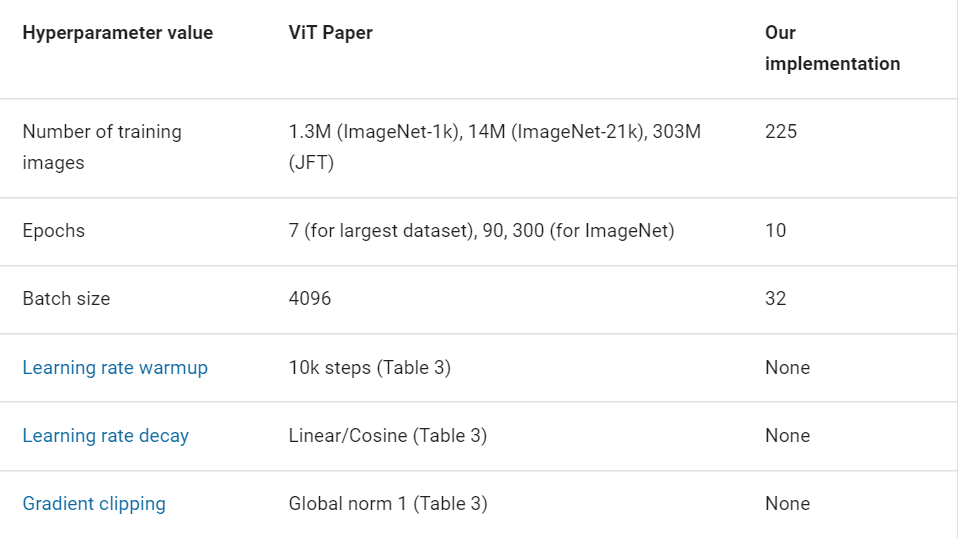

#### 9.5 Plot the loss curves of our ViT model

To check out our ViT model's loss curves, we can use the plot_loss_curves function from helper_functions.py we created in 04. PyTorch Custom Datasets section 7.8.

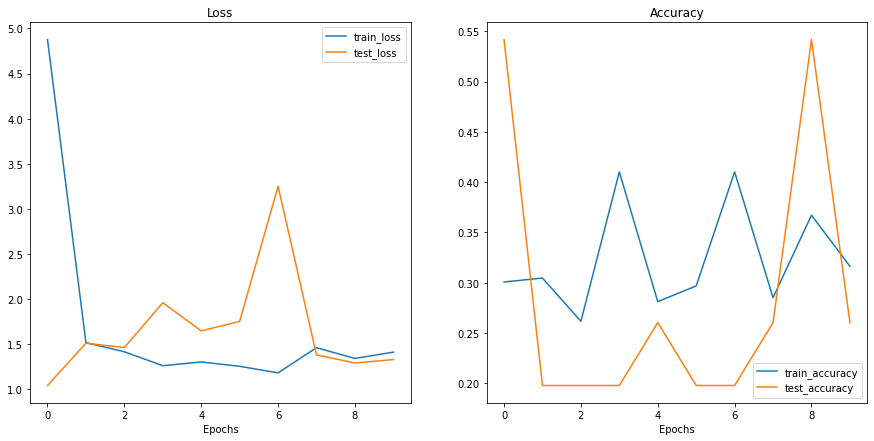

In [55]:
from helper_functions import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

### 10.Using a pretrained ViT from torchvision.models on the same dataset

#### 10.1 Why use a pretrained model?

An important note on many modern machine learning research papers is that much of the results are obtained with large datasets and vast compute resources.

And in modern day machine learning, the original fully trained ViT would likely not be considered a "super large" training setup (models are continually getting bigger and bigger).

#### 10.2 Getting a pretrained ViT model and creating a feature extractor

In [1]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__) 
print(torchvision.__version__)

1.13.0+cu116
0.14.0+cu116


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Finally, we'll get the pretrained ViT-Base with patch size 16 from torchvision.models and prepare it for our FoodVision Mini use case by turning it into a feature extractor transfer learning model.

Specifically, we'll:

1. Get the pretrained weights for ViT-Base trained on ImageNet-1k from torchvision.models.ViT_B_16_Weights.DEFAULT (DEFAULT stands for best available).
2. Setup a ViT model instance via torchvision.models.vit_b_16, pass it the pretrained weights step 1 and send it to the target device.
3. Freeze all of the parameters in the base ViT model created in step 2 by setting their requires_grad attribute to False.
4. Update the classifier head of the ViT model created in step 2 to suit our own problem by changing the number of out_features to our number of classes (pizza, steak, sushi).

In [13]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [14]:
# # Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### 10.3 Preparing data for the pretrained ViT model

In [15]:
from helper_functions import download_data

# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [16]:
# Setup train and test directory paths
train_dir = image_path / "train"
test_dir = image_path / "test" 
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [17]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [18]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

#### 10.4 Train feature extractor ViT model

In [19]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7665 | train_acc: 0.7227 | test_loss: 0.5432 | test_acc: 0.8665
Epoch: 2 | train_loss: 0.3428 | train_acc: 0.9453 | test_loss: 0.3263 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2064 | train_acc: 0.9531 | test_loss: 0.2707 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1556 | train_acc: 0.9570 | test_loss: 0.2422 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1246 | train_acc: 0.9727 | test_loss: 0.2279 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1216 | train_acc: 0.9766 | test_loss: 0.2129 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0938 | train_acc: 0.9766 | test_loss: 0.2352 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0797 | train_acc: 0.9844 | test_loss: 0.2281 | test_acc: 0.8778
Epoch: 9 | train_loss: 0.1098 | train_acc: 0.9883 | test_loss: 0.2074 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0650 | train_acc: 0.9883 | test_loss: 0.1804 | test_acc: 0.9176


#### 10.5 Plot feature extractor ViT model loss curves

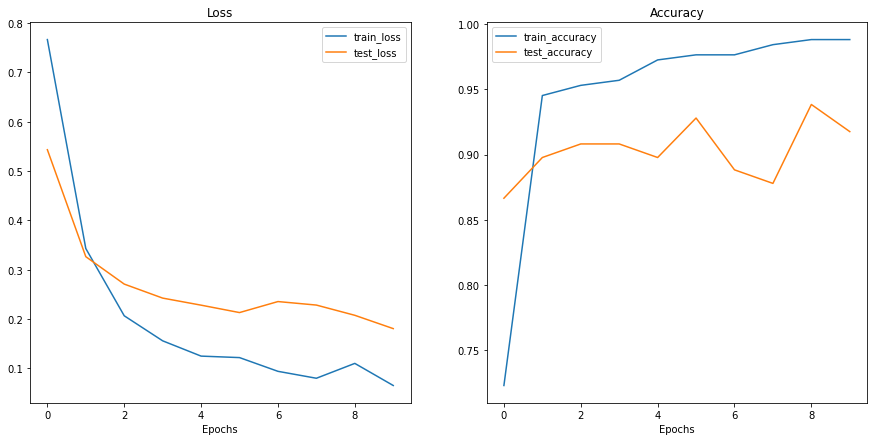

In [20]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

#### 10.6 Save feature extractor ViT model and check file size

In [21]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [22]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


### 11.Make predictions on a custom image

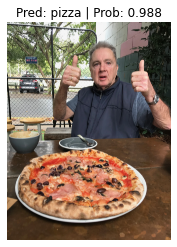

In [23]:
import requests

# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

### Main Takeaways

1. With the explosion of machine learning, new research papers detailing advancements come out every day. And it's impossible to keep up with it all but you can narrow things down to your own use case, such as what we did here, replicating a computer vision paper for FoodVision Mini.

2. Machine learning research papers are often contain months of research by teams of smart people compressed into a few pages (so teasing out all the details and replicating the paper in full can be a bit of challenge).

3. The goal of paper replicating is to turn machine learning research papers (text and math) into usable code.

4. With this being said, many machine learning research teams are starting to publish code with their papers and one of the best places to see this is at Paperswithcode.com

5. Breaking a machine learning research paper into inputs and outputs (what goes in and out of each layer/block/model?) and layers (how does each layer manipulate the input?) and blocks (a collection of layers) and replicating each part step by step (like we've done in this notebook) can be very helpful for understanding.

6. Pretrained models are available for many state of the art model architectures and with the power of transfer learning, these often perform very well with little data.

7. Larger models generally perform better but have a larger footprint too (they take up more storage space and can take longer to perform inference).

A big question is: deployment wise, is the extra performance of a larger model worth it/aligned with the use case?